## Flowtron Style Transfer Demo

#### Import libraries and setup matplotlib

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd

import json
import sys
import torch
from torch.distributions import Normal

from flowtron import Flowtron
from data import Data
from train import update_params
sys.path.insert(0, "tacotron2")
sys.path.insert(0, "tacotron2/waveglow")
from tacotron2.waveglow.denoiser import Denoiser

#### Load Flowtron

In [2]:
config_path = "config.json"
params = ["model_config.dummy_speaker_embedding=0",
          "data_config.p_arpabet=1.0"]

with open(config_path) as f:
    data = f.read()

config = json.loads(data)
update_params(config, params)

data_config = config["data_config"]
model_config = config["model_config"]

model_config.dummy_speaker_embedding=0
dummy_speaker_embedding=0
data_config.p_arpabet=1.0
p_arpabet=1.0


In [3]:
model_path = "checkpoints/flowtron_ljs.pt"
state_dict = torch.load(model_path, map_location='cpu')['state_dict']
model = Flowtron(**model_config)
model.load_state_dict(state_dict)
_ = model.eval().cuda()

#### Load WaveGlow

In [4]:
waveglow_path = 'checkpoints/waveglow.pt'
waveglow = torch.load(waveglow_path)['model']
_ = waveglow.eval().cuda()
denoiser = Denoiser(waveglow).cuda().eval()

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

#### Download samples with surprised style and unzip them in the 'data' folder
[Surprised samples](https://drive.google.com/file/d/100YJu80Y-k5katrwzzE6rFoEHJ2rLmkc/view?usp=sharing) https://drive.google.com/file/d/100YJu80Y-k5katrwzzE6rFoEHJ2rLmkc/view?usp=sharing

#### Prepare the dataloader

In [5]:
dataset_path = 'data/surprised_samples/one_text.txt'
dataset = Data(
    dataset_path,
    **dict((k, v) for k, v in data_config.items() if k not in ['training_files', 'validation_files']))

Number of speakers : 1
Number of speakers : 1


#### Collect z values

torch.Size([128, 1, 80])
torch.Size([1, 80, 128])


/workspace/project-cpfs-10935-sh/cjcode/flowtron/data.py:39: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(data).float(), sampling_rate


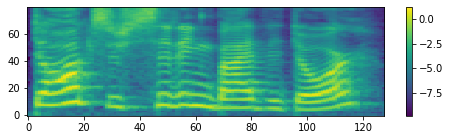

In [6]:
z_values = []
force_speaker_id = 0
for i in range(len(dataset)):
    mel, sid, text, attn_prior = dataset[i]
    fig, axes = plt.subplots(1, 1, figsize=(8, 2))
    im = axes.imshow(mel.cpu(), aspect='auto', origin='lower', interpolation='none')
    plt.colorbar(im, ax=axes)
    mel, sid, text = mel[None].cuda(), sid.cuda(), text[None].cuda()
    if force_speaker_id > -1:
        sid = sid * 0 + force_speaker_id
    in_lens = torch.LongTensor([text.shape[1]]).cuda()
    out_lens = torch.LongTensor([mel.shape[2]]).cuda()
    with torch.no_grad():
        z = model(mel, sid, text, in_lens, out_lens)[0]
        print(z.shape)
        z_values.append(z.permute(1, 2, 0))

for z in z_values:
    print(z.shape)

#### Compute the posterior distribution

In [7]:
lambd = 0.0001
sigma = 1.
n_frames = 300
aggregation_type = 'time_and_batch'

if aggregation_type == 'time_and_batch':
    z_mean = torch.cat([z.mean(dim=2) for z in z_values])
    print(z_mean.shape)
    z_mean = torch.mean(z_mean, dim=0)[:, None]
    print(z_mean.shape)
    ratio = len(z_values) / lambd
    mu_posterior = (ratio * z_mean / (ratio + 1))
    print(mu_posterior.shape)
    
elif aggregation_type == 'batch':    
    for k in range(len(z_values)):
        expand = z_values[k]
        while expand.size(2) < n_frames:
            expand = torch.cat((expand, z_values[k]), 2)
        z_values[k] = expand[:, :, :n_frames]

    z_mean = torch.mean(torch.cat(z_values, dim=0), dim=0)[None]
    print(z_mean.shape)
    z_mean_size = z_mean.size()
    z_mean = z_mean.flatten()
    print(z_mean.shape)
    ratio = len(z_values) / float(lambd)
    mu_posterior = (ratio * z_mean / (ratio + 1)).flatten()
    print(mu_posterior.shape)
    mu_posterior = mu_posterior.view(80, -1)
    print(mu_posterior.shape)

print(ratio)
dist = Normal(mu_posterior.cpu(), sigma)

torch.Size([1, 80])
torch.Size([80, 1])
torch.Size([80, 1])
10000.0


In [8]:
z_baseline = torch.FloatTensor(1, 80, n_frames).cuda().normal_() * sigma
if aggregation_type == 'time_and_batch':
    z_posterior = dist.sample([n_frames]).permute(2,1,0).cuda()
    print(z_posterior.shape)
elif aggregation_type == 'batch':
    z_posterior = dist.sample().view(1, 80, -1)[..., :n_frames].cuda()
    print(z_posterior.shape)

torch.Size([1, 80, 300])


In [9]:
text = "Humans are walking on the streets?"
text_encoded = dataset.get_text(text).cuda()[None]

#### Perform inference sampling the posterior and a standard gaussian baseline

In [10]:
speaker = 0
speaker_id = torch.LongTensor([speaker]).cuda()
with torch.no_grad():
    mel_posterior = model.infer(z_posterior, speaker_id, text_encoded)[0]
    mel_baseline = model.infer(z_baseline, speaker_id, text_encoded)[0]

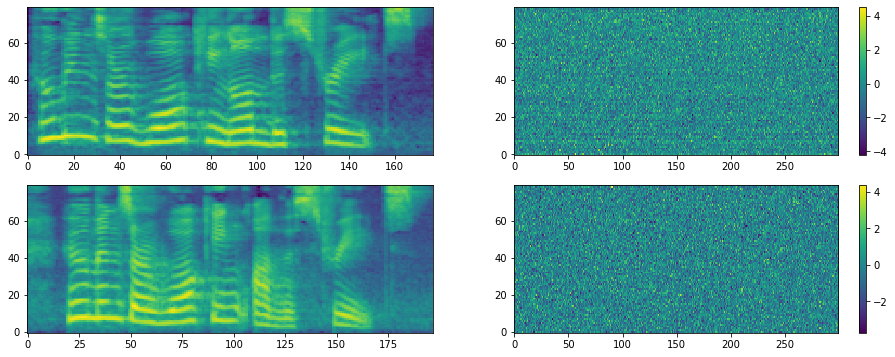

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 6))
axes[0, 0].imshow(mel_posterior[0].cpu(), aspect='auto', origin='lower', interpolation='none')
im = axes[0, 1].imshow(z_posterior[0].cpu(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar(im, ax=axes[0, 1])
axes[1, 0].imshow(mel_baseline[0].cpu(), aspect='auto', origin='lower', interpolation='none')
im = axes[1, 1].imshow(z_baseline[0].cpu(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar(im, ax=axes[1, 1])

#### Posterior sample

In [12]:
with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_posterior, sigma=0.75), 0.01)
ipd.Audio(audio[0].data.cpu().numpy(), rate=data_config['sampling_rate'])

#### Baseline sample

In [13]:
with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_baseline, sigma=0.75), 0.01)
ipd.Audio(audio[0].data.cpu().numpy(), rate=data_config['sampling_rate'])